### Import libraries

In [110]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Unigram Language Model

In [111]:
class UnigramLanguageModel:
    def __init__(self, titles, smoothing=True, isCollection=False):
        '''
            titles: list of lists of words (e.g. [["hello", "world"], ["how", "are", "you"]])
        '''
        
        self.titles = []

        self.smoothing = smoothing
        self.isCollection = isCollection

        self.word_frequency = {}
        self.total_count = 0

        for each_prod in titles:
            new_title = []
            for each_word in each_prod:
                self.total_count += 1
                new_title.append(each_word.lower())

                if each_word not in self.word_frequency:
                    self.word_frequency[each_word] = 1
                else:
                    self.word_frequency[each_word] += 1
            
            self.titles.append(new_title)

    def calculate_unigram_probability(self, word):
        try:
            return self.word_frequency[word] / self.total_count
        except:
            if(self.smoothing and self.isCollection):
                return 1/(self.total_count + len(self.word_frequency))
            return 0

    def calculate_sentence_probability(self, sentence, normalize_probability=True):
        '''
            calculate score/probability of a sentence or query using the unigram language model.
            sentence: input sentence or query
            normalize_probability: If true then log of probability is not computed. Otherwise take log2 of the probability score.
        '''
        score = 1
        for each_word in sentence:
            score *= self.calculate_unigram_probability(each_word)
        
        return score

### Interpolated sentence probability

In [112]:
def calculate_interpolated_sentence_probability(sentence, doc, collection, alpha=0.75, normalize_probability=True):
    '''
        calculate interpolated sentence/query probability using both sentence and collection unigram models.
        sentence: input sentence/query
        doc: unigram language model a doc. HINT: this can be an instance of the UnigramLanguageModel class
        collection: unigram language model a collection. HINT: this can be an instance of the UnigramLanguageModel class
        alpha: the hyperparameter to combine the two probability scores coming from the document and collection language models.
        normalize_probability: If true then log of probability is not computed. Otherwise take log2 of the probability score.
    '''
    score = 1
    
    if(type(sentence) == str):
        query = sentence.lower().split()
    else:
        query = sentence
    
    if query in doc.titles:
        return 1

    for each_word in query:
        doc_prob = alpha * doc.calculate_unigram_probability(each_word)
        collection_prob = (1-alpha) * collection.calculate_unigram_probability(each_word)
        score *= (doc_prob + collection_prob)
    
    return score

### Function to read CSV

In [113]:
def read_csv_titles(file_name):
    df = pd.read_csv(file_name)
    all_titles = df["title"]
    all_filenames = df["image"]
    
    list_of_titles = all_titles.tolist()
    list_of_filenames = all_filenames.tolist()
    
    processed_titles = []

    # we are only seperating by strings, not accounting for stuff like '/' and '-'
    # so dashes will come up as "words" in this model

    # TODO: pre-process the words by making them lower case
    for each_title in list_of_titles:
        processed_titles.append(each_title.lower().split())
    
    return processed_titles, list_of_filenames

### Setting up Unigram Models

In [114]:
train_file = 'train.csv'
train_titles, filenames = read_csv_titles(train_file)

smoothing=True

# Setting up Unigram model for entire collection
collection_model = UnigramLanguageModel(train_titles, smoothing, isCollection=True) # train model is our entire corpus

query = "men body lotion water spray"

In [115]:
def find_matching_document(query, collection_model):
    # for each title in train.csv, we make a model for them
    # interpolated score is then calculated for each title
    # retrieve top 5 scores
    
    all_scores = []

    for doc in range(len(train_titles)):
        current_model = UnigramLanguageModel([train_titles[doc]], smoothing)

        current_score = calculate_interpolated_sentence_probability(query, current_model, collection_model)
        all_scores.append(current_score)

    top_five_indices = sorted(range(len(all_scores)), key=lambda i: all_scores[i])[-5:]
    top_five_scores = sorted(all_scores)[-5:]

    for i in range(0, 5):
        print(f"{i+1}, Index: {top_five_indices[4-i]}, Score: {top_five_scores[4-i]}, Title: {train_titles[top_five_indices[4-i]]}")
        
    return top_five_indices

In [118]:
def search_product(query):
    top_five_indices = find_matching_document(query, collection_model)
    top_five_filenames = []

    for i in top_five_indices:
        top_five_filenames.append(filenames[i])

    path_to_images = 'train/train_images/'
    top_five_image_paths = []
    for i in range(len(top_five_filenames)):
        file_abs_path = path_to_images + top_five_filenames[i]
        top_five_image_paths.append(file_abs_path)


    # Read images
    img1 = mpimg.imread(top_five_image_paths[4])
    img2 = mpimg.imread(top_five_image_paths[3])
    img3 = mpimg.imread(top_five_image_paths[2])
    img4 = mpimg.imread(top_five_image_paths[1])
    img5 = mpimg.imread(top_five_image_paths[0])

    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols=5,figsize=(100,100))

    # show images
    ax1.imshow(img1)
    ax1.set_title("Image 1")
    ax2.imshow(img2)
    ax2.set_title("Image 2")
    ax3.imshow(img3)
    ax3.set_title("Image 3")
    ax4.imshow(img4)
    ax4.set_title("Image 4")
    ax5.imshow(img5)
    ax5.set_title("Image 5")

    plt.show()

### Search for relevant document

To search, change the value of query to the what you want (e.g. query = "victoria secret paper bag")

1, Index: 11967, Score: 1.330417277083675e-12, Title: ['lemonilo', 'mie', 'kuah', 'dan', 'goreng', 'instant', 'sehat', 'organic', 'bayam', 'rendah', 'kalori']
2, Index: 33889, Score: 1.61258981959553e-14, Title: ['lemonilo', 'mie', 'goreng', '&', 'kuah', 'instant', 'sehat', '70gr', '-', 'mie', 'organik', '/', 'lemonilo', 'mie', 'instan']
3, Index: 20450, Score: 5.587489228542763e-17, Title: ['lemonilo', 'mie', 'goreng', 'instant', 'sehat', '-', 'mie', 'organic']
4, Index: 7051, Score: 5.587489228542763e-17, Title: ['lemonilo', 'mie', 'goreng', 'instant', 'sehat', '-', 'mie', 'organic']
5, Index: 23980, Score: 5.4015680328356605e-17, Title: ['lemonilo', 'mie', 'instant', 'sehat', 'mie', 'kuah', '70gr', '-', 'mie', 'organik', '/', 'lemonilo', 'mie', 'instan']


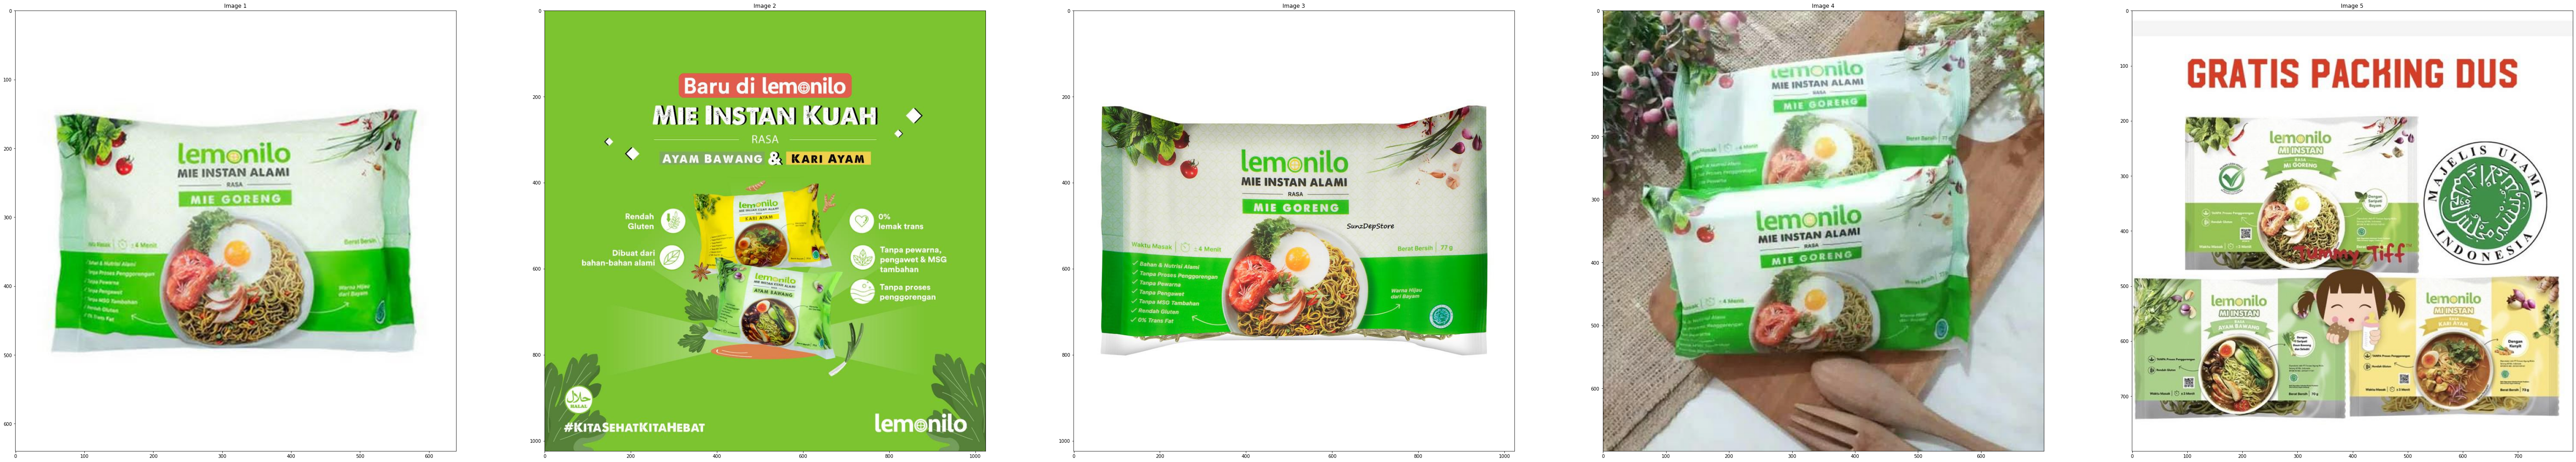

In [119]:
query = "READY Lemonilo Mie instant sehat kuah dan goreng"

search_product(query)

## MAP scoring 

### This takes a few hours to run, the top-k predicted values can be found in Unigram_results.csv

In [120]:
def MAP_score(gold, predicted):
    '''
        gold (list) - matches in gold.csv
        predicted (list) - list containing posting id of top n documents
        
        e.g. gold = ['train_129225211', 'train_2278313361']
             predicted = ['train_129225211', 'train_1203498230']
    '''
    threshold = len(gold)
    
    recall = []
    precision = []
    
    relevant_indexes = []
    
    num_relevant = 0
    current_count = 0
    
    for i in range(len(predicted)):
        current_count += 1
        if(predicted[i] in gold):
            relevant_indexes.append(i)
            
            num_relevant += 1
            recall.append(num_relevant/threshold)
            precision.append(num_relevant/current_count)
            
        else:
            recall.append(num_relevant/threshold)
            precision.append(num_relevant/current_count)
        
    final_score = 0
    for i in relevant_indexes:
        final_score += precision[i]
    
    if(len(relevant_indexes) != 0):
        final_score /= len(relevant_indexes)
    else:
        return 0
    
    return final_score


def all_MAP_scores(predicted, gold=None):
    '''
        predicted (list of lists): each inner list should consist of all the posting id sorted with [most relevant, ..., least relevant]
    '''
    if(gold==None):
        gold = []
        # read csv and save gold into a list of list
        df = pandas.read_csv('gold.csv')
        matches = df["matches"]

        for i in matches:
            line = re.sub("['\[\]]", '', i)
            gold.append(line.split())
        
    
    total_score = 0
    iterations = 500
    #for index in range(500):
    for index in range(len(gold)):
        num_relevant = len(gold[index])
        top_predicted = predicted[index]
        
        total_score += MAP_score(gold[index], top_predicted)
    
    MAP = total_score/len(gold)
    
    return MAP

In [121]:
def get_all_product_titles():
    df = pd.read_csv('train.csv')
    titles = df["title"]
    posting_id = df["posting_id"]
    
    processed_titles = []
    for each_title in titles:
        processed_titles.append(each_title.lower().split())
    
    return processed_titles, posting_id.tolist()

def get_all_gold():
    gold = []
    # read csv and save gold into a list of list
    df = pd.read_csv('gold.csv')
    matches = df["matches"]

    for i in matches:
        line = re.sub("['\[\]]", '', i)
        gold.append(line.split())
    return gold


In [122]:
def find_matches(query, collection_model, all_document_models, number_relevant, all_posting_ids):
    # for each title in train.csv, we make a model for them
    # interpolated score is then calculated for each title
    # retrieve top 5 scores
    
    all_scores = []
    
    for i in all_document_models:
        current_score = calculate_interpolated_sentence_probability(query, i, collection_model)
        all_scores.append(current_score)
    
    top_n_relevant = sorted(range(len(all_scores)), key=lambda i: all_scores[i])[-number_relevant:]
    
#     print("Top relevant", top_n_relevant)
#     for i in top_n_relevant:
#         print(all_scores[i], end='')
#     print()
        
    
    top_n_relevant.reverse()
    predicted_posting_id = []
    for i in top_n_relevant:
        predicted_posting_id.append(all_posting_ids[i])
    
#     print("Posting ids:", predicted_posting_id)
    
    return predicted_posting_id

In [123]:
gold_matches = get_all_gold()
all_titles, all_posting_ids = get_all_product_titles()


# Language models come in here
smoothing = True
collection_model = UnigramLanguageModel(train_titles, smoothing, isCollection=True) # train model is our entire corpus
all_document_models = []

for i in range(len(all_titles)):
    current_model = UnigramLanguageModel([all_titles[i]], smoothing)
    all_document_models.append(current_model)


# For each product, we generate query and get top N predicted
all_predicted = []
for each_product_index in range(len(gold_matches)):
    if(each_product_index != 0):
        if(each_product_index % 100 == 0):
            print(each_product_index)
    number_relevant = len(gold_matches[each_product_index])
    
    current_predicted_posting_ids = find_matches(all_titles[each_product_index], collection_model, all_document_models, number_relevant, all_posting_ids)
    all_predicted.append(current_predicted_posting_ids)

to_save = pd.DataFrame(all_predicted)
to_save.to_csv('Unigram_results_500.csv')

final_MAP_score = all_MAP_scores(all_predicted, gold_matches)

100
200
300
400


In [124]:
print("Unigram MAP Score:", final_MAP_score)

Unigram MAP Score: 0.9665182096569119
